In [1]:
import numpy as np
import pandas as pd
from ortools.linear_solver import pywraplp
from scipy.spatial.distance import euclidean

In [2]:
# !pip install ortools

  Using cached ortools-9.11.4210-cp311-cp311-macosx_11_0_arm64.whl.metadata (3.0 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached protobuf-5.26.1-cp37-abi3-macosx_10_9_universal2.whl.metadata (592 bytes)
  Using cached immutabledict-4.2.1-py3-none-any.whl.metadata (3.5 kB)
Using cached ortools-9.11.4210-cp311-cp311-macosx_11_0_arm64.whl (20.7 MB)
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
Using cached immutabledict-4.2.1-py3-none-any.whl (4.7 kB)
Using cached protobuf-5.26.1-cp37-abi3-macosx_10_9_universal2.whl (404 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.30.0 requires protobuf<5,>=3.20, but you have protobuf 5.26.1 which is incompati

In [ ]:
import numpy as np
import pandas as pd

def build_downturn_matrices(df,
                            downturn_months,
                            recent_month,
                            month_col="month",
                            bin_col="bin",
                            mean_col="Y_actual",
                            cnt_down_col="count",    # NEW
                            cnt_recent_col="count"   # NEW
                            ):
    """
    ------------------------------------------------------------------
      M_down   : lower-triangle weighted means (downturn months)
      P_recent : lower-triangle % record share  (recent month)
      W_down   : element-wise product  M_down * P_recent
      bins     : ordered list of bin labels
    ------------------------------------------------------------------
    Different count columns can be supplied for downturn vs recent data:
        • cnt_down_col    — used as weights in downturn window
        • cnt_recent_col  — used for both weights and shares in recent month
    ------------------------------------------------------------------
    """

    # ---------- 1. filter slices ----------------------------------------
    df_down   = df[df[month_col].isin(downturn_months)].copy()
    df_recent = df[df[month_col] == recent_month].copy()
    if df_down.empty:
        raise ValueError("No rows for downturn_months")
    if df_recent.empty:
        raise ValueError("No rows for recent_month")

    bins = sorted(df[bin_col].unique())
    n    = len(bins)

    # ---------- 2. helper: weighted mean & count ------------------------
    def agg(sub, cnt_col):
        g = (sub.groupby(bin_col)
                  .apply(lambda d: pd.Series({
                      "w_mean": np.average(d[mean_col], weights=d[cnt_col]),
                      "w_cnt" : d[cnt_col].sum()
                  }))
                  .reindex(bins, fill_value=0))
        return g["w_mean"].values, g["w_cnt"].values

    mean_down,  cnt_down   = agg(df_down,   cnt_down_col)
    _,           cnt_recent = agg(df_recent, cnt_recent_col)   # mean not needed
    tot_recent = cnt_recent.sum()
    if tot_recent == 0:
        raise ValueError("recent_month counts sum to 0")

    # ---------- 3. fill lower-triangle ----------------------------------
    def fill_lower(mean_vec, cnt_vec, normalise=False):
        M = np.zeros((n, n))
        for j in range(n):
            m_block = mean_vec[j]
            c_block = cnt_vec[j]
            M[j, j] = (c_block / tot_recent) if normalise else m_block
            for i in range(j+1, n):
                m_block = (m_block*c_block + mean_vec[i]*cnt_vec[i]) \
                          / (c_block + cnt_vec[i])
                c_block += cnt_vec[i]
                M[i, j] = (c_block / tot_recent) if normalise else m_block
        return M

    M_down   = fill_lower(mean_down,  cnt_down,   normalise=False)
    P_recent = fill_lower(cnt_recent, cnt_recent, normalise=True)

    # ---------- 4. exposure-scaled downturn mean ------------------------
    W_down = M_down * P_recent

    return M_down, P_recent, W_down, bins

In [ ]:
import numpy as np
import pandas as pd

def build_cross_matrix(df,
                       month_col="month",
                       bin_col="bin",
                       value_col="Y_actual",
                       weight_col=None):
    """
    --------------------------------------------------------------
    C[i,j]  = number (0,1,2) of immediate-neighbour crossings
              for the merged block  j…i.

    If weight_col is provided:
        • monthly means are weighted by that column
        • merging weights are the per-month *sum* of that column.
    --------------------------------------------------------------
    Returns
    -------
    C     : lower-triangle numpy array  (shape n×n)
    bins  : ordered list of bin labels
    --------------------------------------------------------------
    """

    # -------- 0. baseline sets -----------------------------------------
    bins   = sorted(df[bin_col].unique())
    months = sorted(df[month_col].unique())
    n      = len(bins)

    # -------- 1. per-bin, per-month stats ------------------------------
    vec  = {}      # mean vector μ_{b,m}
    wvec = {}      # per-month weight counts  w_{b,m}

    for b in bins:
        sub = df[df[bin_col] == b]

        if weight_col is None:
            # simple mean
            mu = (sub.groupby(month_col)[value_col]
                     .mean()
                     .reindex(months, fill_value=np.nan)
                     .values)
            w  = (sub.groupby(month_col).size()
                     .reindex(months, fill_value=0)
                     .values)
        else:
            # weighted mean
            mu = (sub.groupby(month_col)
                     .apply(lambda g: np.average(g[value_col],
                                                 weights=g[weight_col]))
                     .reindex(months, fill_value=np.nan)
                     .values)
            w  = (sub.groupby(month_col)[weight_col]
                     .sum()
                     .reindex(months, fill_value=0)
                     .values)

        vec[b]  = mu
        wvec[b] = w

    # -------- 2. helper to merge two vectors (weight per month) --------
    def merge(v1, w1, v2, w2):
        tot = w1 + w2
        with np.errstate(divide='ignore', invalid='ignore'):
            merged = np.divide(v1*w1 + v2*w2,
                               tot,
                               out=np.zeros_like(v1),
                               where=tot != 0)
        return merged, tot

    # -------- 3. build crossing matrix --------------------------------
    C = np.zeros((n, n), dtype=int)

    for j in range(n):
        v_block, w_block = vec[j], wvec[j]

        for i in range(j, n):
            if i > j:
                v_block, w_block = merge(v_block, w_block,
                                         vec[i],   wvec[i])

            cross = 0
            # right neighbour: bin i+1
            if i < n-1:
                if np.any(v_block > vec[i+1]):
                    cross += 1

            # left neighbour: bin j-1
            if j > 0:
                if np.any(v_block < vec[j-1]):
                    cross += 1

            C[i, j] = cross

    return C, bins


# user-supplied limits
min_cross = 0          # e.g. forbid crossings
max_cross = 0          # 0 ⇔ absolute monotone, or set 1 / 2 for tolerance

# ------------------------------------------------------------------
# 1. build full crossing matrix  (as before)
C, bins = build_cross_matrix(df)

# ------------------------------------------------------------------
# 2. convert to Δ-style incremental matrix
CrossΔ = np.zeros_like(C)
for j in range(len(bins)):
    CrossΔ[j, j] = C[j, j]
    for i in range(j+1, len(bins)):
        CrossΔ[i, j] = C[i, j] - C[i, j+1]

# ------------------------------------------------------------------
# 3. add min/max-crossing constraints
for i in range(n):
    row_cross = solver.Sum(CrossΔ[i, j] * X[i, j] for j in range(i+1))
    solver.Add(row_cross >= min_cross * X[i, i])
    solver.Add(row_cross <= max_cross * X[i, i])

In [1]:
import numpy as np
import pandas as pd
from ortools.linear_solver import pywraplp
from scipy.spatial.distance import euclidean

def generate_synthetic_data():
    """Generates synthetic data where Y_actual and Y_predicted are correlated."""
    np.random.seed(42)
    
    # Define month distribution and observation counts
    months = ["2022-01", "2022-02", "2022-03", "2022-04", "2022-05"]
    obs_per_month = [2000, 5000, 3000, 4000, 2500]  # Variable number of observations per month
    
    data = []
    for month, obs in zip(months, obs_per_month):
        Y_actual = np.random.uniform(0.3, 0.8, obs)
        noise = np.random.normal(0.05, 0.2, obs)
        Y_predicted = np.clip(Y_actual + noise, 0, 1)
        for i in range(obs):
            data.append([
                month,        # Month column
                Y_actual[i],  # Y_actual
                Y_predicted[i],  # Y_predicted
                np.random.rand(),  # ts1
                np.random.rand(),  # ts2
                np.random.rand()   # ts3
            ])
    df = pd.DataFrame(data, columns=["month", "Y_actual", "Y_predicted", "ts1", "ts2", "ts3"])
    return df

def pre_bin_predictions(df, num_bins=10):
    """
    Perform equal-sized binning using quantiles (pd.qcut) on Y_predicted.
    (Pre-binning remains unchanged.)
    """
    df["bin"] = pd.qcut(df["Y_predicted"], q=num_bins, labels=False, duplicates='drop')
    return df

def compute_euclidean_distance_matrix(df):
    """
    Compute Euclidean distance matrix between pre-bins based on the mean of Y_predicted.
    """
    unique_bins = sorted(df["bin"].unique())
    n_bins = len(unique_bins)
    distance_matrix = np.zeros((n_bins, n_bins))
    for i in range(n_bins):
        for j in range(i, n_bins):
            mean_i = df[df["bin"] == unique_bins[i]]["Y_predicted"].mean()
            mean_j = df[df["bin"] == unique_bins[j]]["Y_predicted"].mean()
            distance_matrix[i, j] = distance_matrix[j, i] = euclidean([mean_i], [mean_j])
    return distance_matrix, unique_bins

import numpy as np

def lift_area_matrix_negative_cumulative_forward(df, month_col="month"):
    """
    ---------------------------------------------------------------
    Build a lower–triangle matrix  D  (shape n_bins × n_bins)
    ---------------------------------------------------------------
    Idea
    ----
    For *every* block  j…i   (j ≤ i)

        1.  Keep that block frozen.
        2.  Look only to the RIGHT:
                neighbour_1 = bin (i+1)
                neighbour_2 = bins (i+1 , i+2)
                neighbour_3 = bins (i+1 , i+2 , i+3)
                ...
        3.  For each neighbour_k compute the **negative-only** gap
                gap_k = Σ_m  min( 0 , μ_neigh_k,m  –  μ_block,m )
        4.  D[i,j] = cumulative SUM of all those gaps
           (the value is ≤ 0, or 0 if i is the last bin).

    Why the Δ-table will be ≥ 0
    ---------------------------
    As we extend the block one bin to the left (j → j-1)  
    • the *same* neighbour suite is used,  
    • one *new* negative gap term is added (≤ 0).  
    Therefore V[i,j-1] ≤ V[i,j] and Δ = V[i,j-1]-V[i,j] ≥ 0.

    Parameters
    ----------
    df         : DataFrame with columns ["bin", month_col, "Y_predicted"]
    month_col  : name of the month column (sortable / datetime)

    Returns
    -------
    D     : numpy array  (lower-triangle filled, upper part = 0)
    bins  : list of ordered pre-bin labels
    """

    # ------------------------------------------------------------
    # 1.  prepare single-bin mean vectors
    # ------------------------------------------------------------
    bins   = sorted(df["bin"].unique())          # e.g. [0,1,…,n-1]
    months = sorted(df[month_col].unique())      # ensure stable order
    n      = len(bins)

    vec = {}     # vec[b] : np.array of monthly means for bin b
    cnt = {}
    for b in bins:
        sub = df[df["bin"] == b]
        v   = (sub.groupby(month_col)["Y_predicted"]
                     .mean()
                     .reindex(months)
                     .values)
        vec[b] = v
        cnt[b] = len(sub)

    def merge(v1, c1, v2, c2):
        """weighted merge of two mean vectors"""
        tot = c1 + c2
        return (v1 * c1 + v2 * c2) / tot, tot

    # ------------------------------------------------------------
    # 2.  build lower-triangle D
    # ------------------------------------------------------------
    D = np.zeros((n, n))          # upper triangle stays 0

    for i in range(n - 1):        # last row (i = n-1) will stay zeros
        # right-hand cumulative neighbour vector, start with single bin i+1
        right_vec, right_cnt = vec[i + 1], cnt[i + 1]

        # block initial = single bin i
        block_vec, block_cnt = vec[i], cnt[i]

        # ---- D[i,i]  (single block vs single neighbour) -------------
        gap = np.minimum(0, right_vec - block_vec).sum()
        D[i, i] = gap      # ≤ 0

        # pre-compute a list of cumulative right neighbours to speed up
        right_cumulatives = [(right_vec, right_cnt)]
        for k in range(i + 2, n):
            right_vec, right_cnt = merge(right_vec, right_cnt,
                                         vec[k],     cnt[k])
            right_cumulatives.append((right_vec, right_cnt))

        # ---- extend block leftwards ---------------------------------
        for j in range(i - 1, -1, -1):
            # enlarge block by adding one bin on the left
            block_vec, block_cnt = merge(vec[j], cnt[j],
                                         block_vec, block_cnt)

            # compute cumulative negative gap against *every* neighbour_k
            cum_gap = 0.0
            for right_vec, _ in right_cumulatives:
                cum_gap += np.minimum(0, right_vec - block_vec).sum()

            D[i, j] = cum_gap      # ≤ 0  (more negative or equal)

    # last row (i = n-1) has no neighbour on the right → stays zeros
    return D, bins







def optimize_binning(distance_matrix,bin_percents,df,
                     min_bin_pct=0.10, min_bins=3, max_bins=6):
    """
    distance_matrix[i,j] (i >= j) must hold the score for the *whole* merged
    range j…i.  We convert it to an incremental (delta) table ∆ so that ranges
    are not double-counted, exactly like optbinning does for IV.
    """
    n = distance_matrix.shape[0]
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # ------------------------------------------------------------------ #
    # 1.  Decision variables  X[i,j]   (lower triangle: j ≤ i)
    # ------------------------------------------------------------------ #
    X = {(i, j): solver.BoolVar(f'X[{i},{j}]')
         for i in range(n)
         for j in range(i + 1)}          # j = 0 … i

    # ------------------------------------------------------------------ #
    # 2.  Build the *delta* matrix  Δ[i,j]  (incremental reward)
    #     Δ[i,j] = distance(j…i) − distance(j…i-1)
    # ------------------------------------------------------------------ #

    # 2. Build incremental matrix Δ  (optbinning-style: subtract D[i,j+1])
    Delta = np.zeros_like(distance_matrix)
    for j in range(n):
        Delta[j, j] = distance_matrix[j, j]             # single bin
        for i in range(j + 1, n):
            Delta[i, j] = distance_matrix[i, j] - distance_matrix[i, j + 1]


    # ------------------------------------------------------------------ #
    # 3.  Objective:  Maximise   Σ Δ[i,j] · X[i,j]
    # ------------------------------------------------------------------ #
    objective = solver.Objective()
    for i in range(n):
        for j in range(i + 1):
            if Delta[i, j] != 0:                      # skip harmless zeros
                objective.SetCoefficient(X[i, j], float(Delta[i, j]))
    objective.SetMaximization()

    # ------------------------------------------------------------------ #
    # 4.  Constraints  (unchanged from your version)
    # ------------------------------------------------------------------ #
    # 4-A  Each pre-bin assigned exactly once
    for j in range(n):
        solver.Add(sum(X[i, j] for i in range(j, n)) == 1)

    # 4-B  Continuity (no gaps)
    for i in range(n):
        for j in range(i):
            solver.Add(X[i, j] <= X[i, j + 1])

    # 4-C  Number of final bins
    solver.Add(sum(X[i, i] for i in range(n)) >= min_bins)
    solver.Add(sum(X[i, i] for i in range(n)) <= max_bins)

    # 4-D  Minimum % size per final bin
    # for i in range(n):
    #     solver.Add(sum(bin_percents[j] * X[i, j] for j in range(i + 1))
    #                >= min_bin_pct * X[i, i])

    for i in range(n):
        solver.Add(sum(bin_percents[j] * X[i,j] for j in range(i+1)) >= min_bin_pct * X[i,i])
        # solver.Add(sum(bin_percents[i,j] * X[i,j] for j in range(i+1)) <= max_pct * X[i,i])

    # ------------------------------------------------------------------
    #   NO‑CROSSING  (monotone means per month)
    # ------------------------------------------------------------------
    S = sign_matrix_no_cross(df)        # +1 / -1 matrix

    # when creating variables
    for i in range(n):
        for j in range(i+1):
            if S[i,j] == -1:
                # force variable to 0  (forbidden)
                solver.Add(X[i,j] == 0)



    # ------------------------------------------------------------------ #
    # 5.  Solve
    # ------------------------------------------------------------------ #
    status = solver.Solve()
    if status not in (pywraplp.Solver.OPTIMAL, pywraplp.Solver.FEASIBLE):
        print("❌ No solution."); return None
    print("✅ Status:", "Optimal" if status==pywraplp.Solver.OPTIMAL else "Feasible",
          " Obj=", solver.Objective().Value())

    # ------------------------------------------------------------------ #
    # 6.  Extract merged bins
    # ------------------------------------------------------------------ #
    merged = {}
    for i in range(n):
        for j in range(i + 1):
            if X[i, j].solution_value() > 0.5:
                merged.setdefault(i, []).append(j)

    # 🔸------------------------------------------------------------
    #   Build cut-points array for pd.cut
    #   edge of a final grade = min(Y_pred) of first pre-bin in block
    #                           up to max(Y_pred) of last pre-bin
    #   1) get pre-bin score ranges
    # pre_edges = (df.groupby("bin")["Y_predicted"]
    #                .agg(["min","max"])
    #                .sort_index())
    # #   2) collect boundaries
    # boundaries = []
    # for row_start, pre_list in sorted(merged.items()):
    #     left  = pre_edges.loc[min(pre_list), "min"]
    #     right = pre_edges.loc[max(pre_list), "max"]
    #     boundaries.append(left)
    #     # keep right of last bin for final edge later
    #     last_right = right
    # boundaries.append(last_right)

    # cuts = np.array([-np.inf] + sorted(boundaries) + [np.inf])
    # 🔸------------------------------------------------------------

    # gather left & right boundaries of each chosen block
    # final_edges = [-np.inf]
    # for row_start in sorted(merged):
    #     block_bins = merged[row_start]
    #     left_idx   = min(block_bins)          # first pre-bin in block
    #     right_idx  = max(block_bins) + 1      # +1 to pick *upper* edge
    #     final_edges.append(pre_edges[left_idx])
    #     # save the very last rightmost edge at the end
    #     last_upper = pre_edges[right_idx]
    
    # final_edges.append(last_upper)
    # final_edges.append(np.inf)
    
    # cuts = np.array(sorted(set(final_edges)))   # drop duplicates if any
    
    return merged


def apply_optimal_bins(df, bin_mapping):
    """
    Map the original pre-bins to their corresponding final (optimized) bins.
    """
    bin_map = {old_bin: new_bin for new_bin, old_bins in bin_mapping.items() for old_bin in old_bins}
    df["optimized_bin"] = df["bin"].map(bin_map)
    return df

def aggregate_by_month(df):
    """
    Aggregate the dataset by month and optimized bin.
    """
    agg_df = df.groupby(["month", "optimized_bin"]).agg({
        "Y_actual": ["mean", "count"],
        "Y_predicted": ["mean"]
    }).reset_index()
    agg_df.columns = ["month", "optimized_bin", "Y_actual_mean", "count", "Y_predicted_mean"]
    return agg_df

def compute_bin_min_percentage(df, months_keep=None):
    """
    Returns
    -------
    pct_vec  : numpy array (length n_bins)
        pct_vec[j] = minimum percentage of total records that pre-bin j
                     represents across the selected months.
    bins     : ordered list of bin labels
    """
    if months_keep is not None:
        df = df[df["month"].isin(months_keep)].copy()

    bins = sorted(df["bin"].unique())

    # counts per (month, bin)
    counts = (df.groupby(["month", "bin"])
                .size()
                .unstack(fill_value=0)
                .reindex(columns=bins, fill_value=0))

    # percentage per month
    pct = counts.div(counts.sum(axis=1), axis=0)

    # minimum across months
    pct_vec = pct.min(axis=0).values       # array aligned with bins

    return pct_vec, bins

import numpy as np

def sign_matrix_no_cross(df, month_col="month"):
    """
    Lower‑triangle sign matrix S  (int8):
        S[i,j] = +1   if merged block j…i never crosses bin i+1
               = -1   if it crosses in ANY month
               =  0   for i < j  or  (i == n-1)  (no next bin)

    Uses raw `df` for every merged block — no averaging‑of‑averages.
    """
    bins   = sorted(df["bin"].unique())          # 0 … n-1
    months = sorted(df[month_col].unique())
    n      = len(bins)

    # single‑bin vectors
    vec = {b: (df[df["bin"] == b]
                 .groupby(month_col)["Y_predicted"]
                 .mean()
                 .reindex(months)
                 .fillna(0)
                 .values)
           for b in bins}

    S = np.zeros((n, n), dtype=np.int8)

    # 1. diagonal  (bin k vs bin k+1)
    for k in range(n-1):
        S[k, k] = -1 if np.any(vec[k] > vec[k+1]) else +1
    S[n-1, n-1] = +1                   # right edge (no neighbour)

    # 2. merged blocks  j … i   (exact calc from df slice)
    for j in range(n):
        for i in range(j+1, n-1):      # i == n-1 has no next bin
            block_slice = df[df["bin"].between(j, i)]
            merge_vec   = (block_slice
                           .groupby(month_col)["Y_predicted"]
                           .mean()
                           .reindex(months)
                           .fillna(0)
                           .values)
            S[i, j] = -1 if np.any(merge_vec > vec[i+1]) else +1

    return S


# Main Execution

# Step 1: Generate synthetic data
df = generate_synthetic_data()

# Step 2: Pre-bin Y_predicted using quantiles (we do not change this step)
df = pre_bin_predictions(df, num_bins=5)

# Step 3: Compute Euclidean distance matrix based on Y_predicted only
distance_matrix, unique_bins = lift_area_matrix_negative_cumulative_forward(df)

# Step 4: Compute pre-bin counts (as an array) and total observations.
# We assume the pre-bin labels are sorted as in unique_bins.
bin_counts_series = df["bin"].value_counts().sort_index()
bin_counts = [bin_counts_series.get(b, 0) for b in unique_bins]
total_obs = len(df)
print("Pre-bin counts:", bin_counts)
print("Total observations:", total_obs)
bin_percents, P = compute_bin_min_percentage(df)

# Step 5: Run the optimization with the minimum bin percentage constraint.
# Here, min_bin_pct is defined by the user (e.g., 10%).
min_bin_pct = 0.02  
optimal_bins = optimize_binning(distance_matrix, bin_percents, min_bin_pct=min_bin_pct,df=df,min_bins=2, max_bins=10)

# Step 6: Apply the optimal bin mapping back to the dataset.
df = apply_optimal_bins(df, optimal_bins)

# Step 7: Aggregate results by month and optimized bin.
aggregated_df = aggregate_by_month(df)

# Display results.
print("\nOptimized binning structure:", optimal_bins)
print("\nAggregated data by month and optimized bin:")
print(aggregated_df)

Pre-bin counts: [3300, 3300, 3300, 3300, 3300]
Total observations: 16500
✅ Status: Optimal  Obj= 0.0

Optimized binning structure: {0: [0], 1: [1], 2: [2], 3: [3], 4: [4]}

Aggregated data by month and optimized bin:
      month  optimized_bin  Y_actual_mean  count  Y_predicted_mean
0   2022-01              0       0.424802    405          0.253547
1   2022-01              1       0.490070    387          0.464803
2   2022-01              2       0.553941    393          0.599194
3   2022-01              3       0.602717    403          0.734115
4   2022-01              4       0.670731    412          0.921570
5   2022-02              0       0.433667    978          0.262840
6   2022-02              1       0.492673   1003          0.466962
7   2022-02              2       0.552910    997          0.604334
8   2022-02              3       0.599776   1034          0.735800
9   2022-02              4       0.669942    988          0.921554
10  2022-03              0       0.431409    6

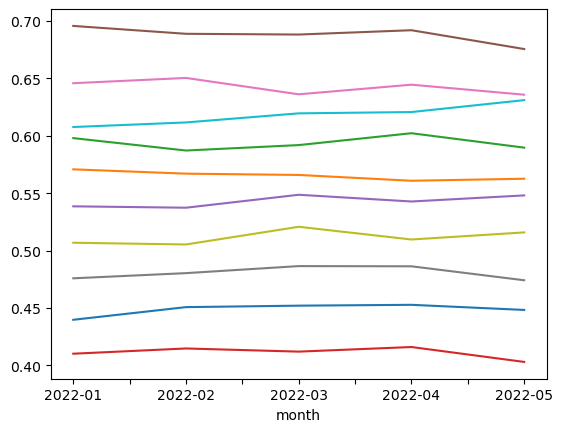

In [114]:
for i in df['optimized_bin'].unique():
    df[df['optimized_bin'] == i].groupby('month')['Y_actual'].mean().plot()

In [ ]:
df=df
month_col="month"
penalty_factor=10

bins   = sorted(df["bin"].unique())
months = sorted(df[month_col].unique())
n      = len(bins)

# -------- single‑bin month vectors + counts --------------------------
vec, cnt = {}, {}
for b in bins:
    sub = df[df["bin"] == b]
    v   = (sub.groupby(month_col)["Y_predicted"]
                .mean()
                .reindex(months)
                .fillna(sub["Y_predicted"].mean())
                .values)
    vec[b] = v
    cnt[b] = len(sub)

def merge(v1,c1, v2,c2):
    tot = c1+c2
    return (v1*c1 + v2*c2)/tot, tot

# cumulative forward / backward means for speed
fwd_vec = {}
for s in range(n):
    v, c = vec[s].copy(), cnt[s]
    fwd_vec[(s, s)] = v
    for k in range(s+1, n):
        v, c = merge(v,c, vec[k], cnt[k])
        fwd_vec[(s, k)] = v

bwd_vec = {}
for e in range(n-1, -1, -1):
    v, c = vec[e].copy(), cnt[e]
    bwd_vec[(e, e)] = v
    for k in range(e-1, -1, -1):
        v, c = merge(v,c, vec[k], cnt[k])
        bwd_vec[(k, e)] = v

# -------- build D ----------------------------------------------------
D = np.zeros((n, n))

for j in range(n):
    v_block, c_block = vec[j].copy(), cnt[j]
    for i in range(j, n):
        if i > j:
            v_block, c_block = merge(v_block, c_block,
                                      vec[i], cnt[i])

        scores = []

        # forward neighbours
        if i < n-1:
            for k in range(i+1, n):
                gap = fwd_vec[(i+1,k)] - v_block
                gap = np.where(gap < 0, gap * penalty_factor, gap)
                scores.append(gap.sum())

        # backward neighbours
        if j > 0:
            for k in range(j-1, -1, -1):
                gap = v_block - bwd_vec[(k, j-1)]
                gap = np.where(gap < 0, gap * penalty_factor, gap)
                scores.append(gap.sum())

        D[i, j] = 0.0 if not scores else np.mean(scores)


In [62]:
solver = pywraplp.Solver.CreateSolver('SCIP')
x = {}
for i in range(10):
    for j in range(i + 1):
        x[i, j] = solver.BoolVar("x[{}, {}]".format(i, j))

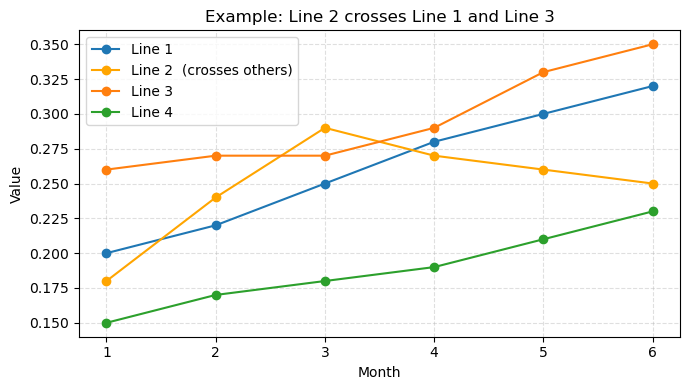

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# dummy time axis
months = np.arange(1, 7)                 # 6 points: 1 … 6

# four simple curves
y1 = np.array([0.20, 0.22, 0.25, 0.28, 0.30, 0.32])   # steadily rising
y2 = np.array([0.18, 0.24, 0.29, 0.27, 0.26, 0.25])   # rises, crosses, then falls
y3 = np.array([0.26, 0.27, 0.27, 0.29, 0.33, 0.35])   # always above y1 until crossed by y2
y4 = np.array([0.15, 0.17, 0.18, 0.19, 0.21, 0.23])   # lower baseline

plt.figure(figsize=(7,4))
plt.plot(months, y1, marker='o', label='Line 1')
plt.plot(months, y2, marker='o', label='Line 2  (crosses others)', color='orange')
plt.plot(months, y3, marker='o', label='Line 3')
plt.plot(months, y4, marker='o', label='Line 4')

plt.xticks(months)
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Example: Line 2 crosses Line 1 and Line 3')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Step 1: Generate synthetic data

In [25]:
df = generate_synthetic_data()
df

,month,Y_actual,Y_predicted,ts1,ts2,ts3
0,2022-01,0.487270,0.443371,0.599299,0.513708,0.288185
1,2022-01,0.775357,0.734013,0.006464,0.496239,0.285626
2,2022-01,0.665997,0.654673,0.734608,0.023946,0.584828
3,2022-01,0.599329,0.617698,0.941474,0.174409,0.471649
4,2022-01,0.378009,0.423689,0.091422,0.625682,0.550532
...,...,...,...,...,...,...
16495,2022-05,0.667716,0.721065,0.276718,0.403522,0.783302
16496,2022-05,0.758227,0.833882,0.954285,0.554236,0.154387
16497,2022-05,0.377578,0.331467,0.214054,0.405372,0.365757
16498,2022-05,0.412207,0.557359,0.238270,0.850228,0.280112


# Step 2: Pre-bin Y_predicted using quantiles (we do not change this step)

In [27]:
df = pre_bin_predictions(df, num_bins=10)
df

,month,Y_actual,Y_predicted,ts1,ts2,ts3,bin
0,2022-01,0.487270,0.443371,0.599299,0.513708,0.288185,2
1,2022-01,0.775357,0.734013,0.006464,0.496239,0.285626,8
2,2022-01,0.665997,0.654673,0.734608,0.023946,0.584828,7
3,2022-01,0.599329,0.617698,0.941474,0.174409,0.471649,6
4,2022-01,0.378009,0.423689,0.091422,0.625682,0.550532,2
...,...,...,...,...,...,...,...
16495,2022-05,0.667716,0.721065,0.276718,0.403522,0.783302,8
16496,2022-05,0.758227,0.833882,0.954285,0.554236,0.154387,9
16497,2022-05,0.377578,0.331467,0.214054,0.405372,0.365757,0
16498,2022-05,0.412207,0.557359,0.238270,0.850228,0.280112,5


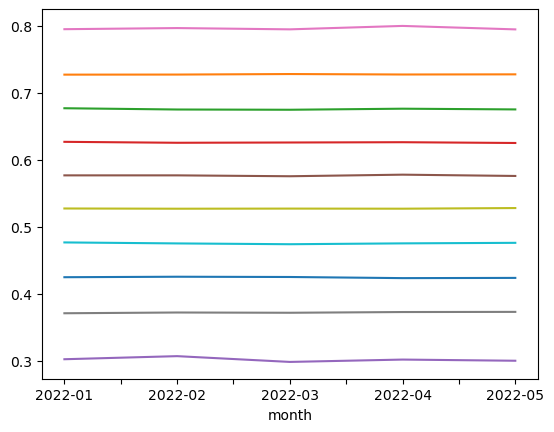

In [29]:
for i in df['bin'].unique():
    df[df['bin'] == i].groupby('month')['Y_predicted'].mean().plot()

# Step 3: Compute Euclidean distance matrix based on Y_predicted only

In [81]:
distance_matrix, unique_bins = distance_matrix_local_neighbors(df)
print(distance_matrix)
print(unique_bins)

[[0.36372149 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.3905229  0.57243329 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.4238622  0.73590898 0.37224297 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.46393489 0.88194005 0.51828807 0.30961471 0.         0.
  0.         0.         0.         0.        ]
 [0.51797842 1.02874573 0.66509589 0.45641064 0.29293454 0.
  0.         0.         0.         0.        ]
 [0.57662281 1.17371315 0.81006285 0.60137429 0.43788555 0.29185563
  0.         0.         0.         0.        ]
 [0.65530213 1.33477035 0.97111892 0.76243152 0.59891779 0.45289753
  0.30612191 0.         0.         0.        ]
 [0.77434956 1.5357203  1.17207896 0.96339635 0.79989058 0.6538471
  0.50704387 0.36218074 0.         0.        ]
 [0.95145787 1.79886791 1.4352142  1.22652935 1.06301982 0.91697715
  0.77015296 0.62520799 0.46427688 0.        ]
 [0.  

In [82]:
pd.DataFrame(distance_matrix)

,0,1,2,3,4,5,6,7,8,9
0,0.363721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.390523,0.572433,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.423862,0.735909,0.372243,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.463935,0.881940,0.518288,0.309615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.517978,1.028746,0.665096,0.456411,0.292935,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.576623,1.173713,0.810063,0.601374,0.437886,0.291856,0.000000,0.000000,0.000000,0.000000
6,0.655302,1.334770,0.971119,0.762432,0.598918,0.452898,0.306122,0.000000,0.000000,0.000000
7,0.774350,1.535720,1.172079,0.963396,0.799891,0.653847,0.507044,0.362181,0.000000,0.000000
8,0.951458,1.798868,1.435214,1.226529,1.063020,0.916977,0.770153,0.625208,0.464277,0.000000
9,0.000000,1.047278,0.769076,0.640447,0.556425,0.492455,0.432025,0.382757,0.332569,0.263213


# Step 4: Compute pre-bin counts (as an array) and total observations.

In [31]:
# We assume the pre-bin labels are sorted as in unique_bins.
bin_counts_series = df["bin"].value_counts().sort_index()
bin_counts = [bin_counts_series.get(b, 0) for b in unique_bins]
total_obs = len(df)
print("Pre-bin counts:", bin_counts)
print("Total observations:", total_obs)

Pre-bin counts: [1650, 1650, 1650, 1650, 1650, 1650, 1650, 1650, 1650, 1650]
Total observations: 16500


# Step 5: Run the optimization with the minimum bin percentage constraint.

In [32]:
# Here, min_bin_pct is defined by the user (e.g., 10%).
min_bin_pct = 0.10  
optimal_bins = optimize_binning(distance_matrix, bin_counts, total_obs, min_bin_pct=min_bin_pct, min_bins=5, max_bins=6)


✅ Optimal solution found with objective value: 1.8810934968625754


# Step 6: Apply the optimal bin mapping back to the dataset.

In [33]:
df = apply_optimal_bins(df, optimal_bins)
df

,month,Y_actual,Y_predicted,ts1,ts2,ts3,bin,optimized_bin
0,2022-01,0.487270,0.443371,0.599299,0.513708,0.288185,2,9
1,2022-01,0.775357,0.734013,0.006464,0.496239,0.285626,8,8
2,2022-01,0.665997,0.654673,0.734608,0.023946,0.584828,7,7
3,2022-01,0.599329,0.617698,0.941474,0.174409,0.471649,6,6
4,2022-01,0.378009,0.423689,0.091422,0.625682,0.550532,2,9
...,...,...,...,...,...,...,...,...
16495,2022-05,0.667716,0.721065,0.276718,0.403522,0.783302,8,8
16496,2022-05,0.758227,0.833882,0.954285,0.554236,0.154387,9,9
16497,2022-05,0.377578,0.331467,0.214054,0.405372,0.365757,0,9
16498,2022-05,0.412207,0.557359,0.238270,0.850228,0.280112,5,5


# Step 7: Aggregate results by month and optimized bin.

In [34]:
aggregated_df = aggregate_by_month(df)
aggregated_df

,month,optimized_bin,Y_actual_mean,count,Y_predicted_mean
0,2022-01,5,0.578350,199,0.577022
1,2022-01,6,0.622386,198,0.627091
2,2022-01,7,0.672003,212,0.677245
3,2022-01,8,0.716470,183,0.727408
4,2022-01,9,0.485707,1208,0.483210
5,2022-02,5,0.576574,499,0.577033
6,2022-02,6,0.623868,480,0.625685
7,2022-02,7,0.676628,496,0.675350
8,2022-02,8,0.721390,487,0.727518
9,2022-02,9,0.486342,3038,0.487061


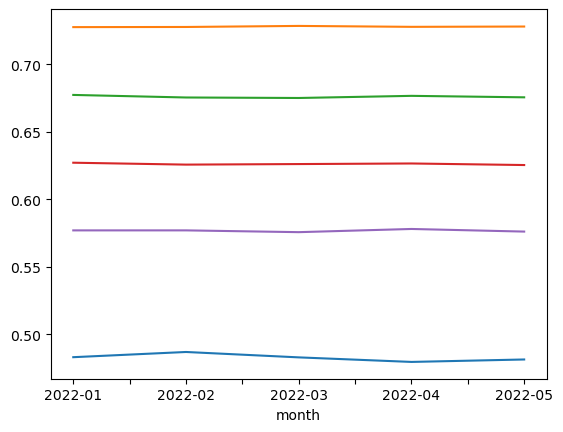

In [35]:
for i in df['optimized_bin'].unique():
    df[df['optimized_bin'] == i].groupby('month')['Y_predicted'].mean().plot()

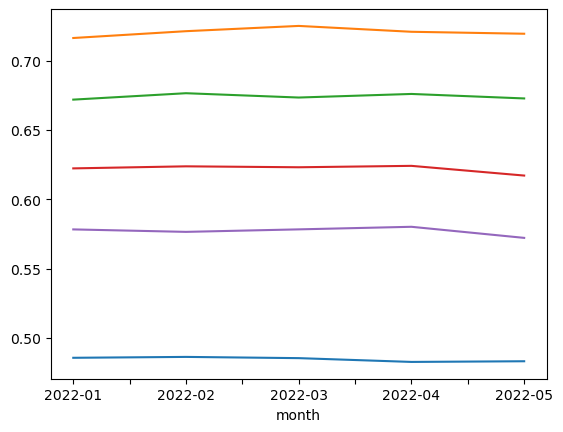

In [36]:
for i in df['optimized_bin'].unique():
    df[df['optimized_bin'] == i].groupby('month')['Y_actual'].mean().plot()

# Playground

In [72]:
def compute_bin_min_percentage(df):
    """Compute the minimum percentage of total observations for each bin across all months."""
    # Compute bin counts by month
    bin_counts_by_month = df.groupby("month")["bin"].value_counts().unstack().fillna(0)
    # print(bin_counts_by_month)
    # Convert counts to percentages
    bin_percentages = bin_counts_by_month.div(bin_counts_by_month.sum(axis=1), axis=0)
    
    # Get the minimum percentage for each bin across all months
    min_bin_percentages = bin_percentages.min(axis=0).to_numpy()
    
    return min_bin_percentages
compute_bin_min_percentage(df)

bin        0    1    2    3    4    5    6    7    8    9
month                                                    
2022-01  204  201  209  178  205  188  204  199  206  206
2022-02  463  515  507  496  473  524  500  534  485  503
2022-03  310  293  318  304  303  277  317  297  276  305
2022-04  423  394  382  418  418  400  405  377  409  374
2022-05  250  247  234  254  251  261  224  243  274  262


array([0.0926    , 0.09766667, 0.0936    , 0.089     , 0.0946    ,
       0.09233333, 0.0896    , 0.09425   , 0.092     , 0.0935    ])

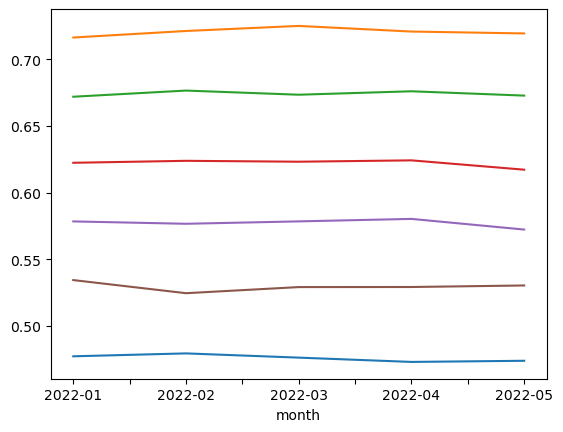

In [28]:
for i in df['optimized_bin'].unique():
    df[df['optimized_bin'] == i].groupby('month')['Y_actual'].mean().plot()

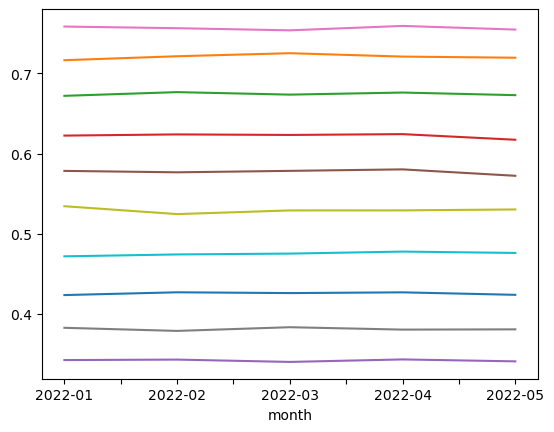

In [54]:
for i in df['optimized_bin'].unique():
    df[df['optimized_bin'] == i].groupby('month')['Y_actual'].mean().plot()

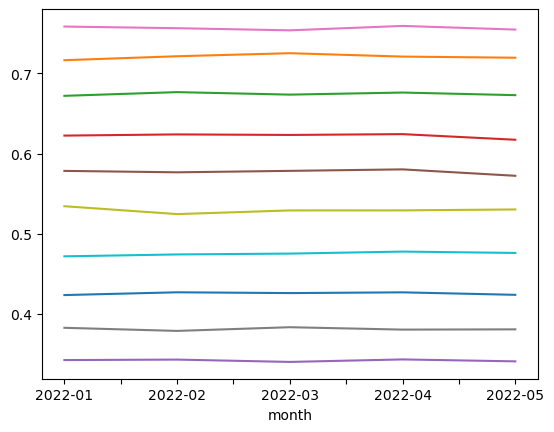

In [19]:
for i in df['bin'].unique():
    df[df['bin'] == i].groupby('month')['Y_actual'].mean().plot()

In [ ]:
for i in df['optimized_bin'].unique():
    df[df['optimized_bin'] == i].groupby('month')['Y_actual'].mean().plot()

In [ ]:
import matplotlib.pyplot as plt

for i in df['optimized_bin'].unique():
    df[df['optimized_bin'] == i].groupby('month')['Y_actual'].mean().plot()
plt.savefig("/Users/maxwerty/Documents/PyCharm/output_opt.png")  # Saves the figure to a file
plt.show()


# Display results
print("\nOptimized binning structure:", optimal_bins)
print("\nAggregated data by month and bin:")